### Reference:

Method here is to have a document(image) retriever to retrieve the relevant documents before feeding to the downstream VLM to answer user query.

![multimodal](img/multimodal.png)

ColPali is designed to be more efficient and effective for document retrieval tasks by generating contextualized embeddings directly from images of document pages. Then the retrieved pages could be used as input to a downstream VLM model. This type of serving architecture could be described as a retrieve and read pipeline or in the case of ColPali, a retrieve and see pipeline.

Note that the ColPali model is not a full VLM like GPT-4o or Gemini Flash, but rather a specialized model for document retrieval. The model is trained to generate embeddings from images of document pages and compare them with query embeddings to retrieve the most relevant documents.

- Vision Language Models: https://huggingface.co/blog/vlms
- Vision Language Models (further): https://huggingface.co/blog/vlms-2025
- PaliGemma: https://huggingface.co/blog/paligemma
- ColPali: https://blog.vespa.ai/the-rise-of-vision-driven-document-retrieval-for-rag/
- RAG + ColPali + VLM: https://huggingface.co/learn/cookbook/en/multimodal_rag_using_document_retrieval_and_vlms
- Above + Reranker: https://huggingface.co/learn/cookbook/en/multimodal_rag_using_document_retrieval_and_reranker_and_vlms


### Download the dataset

In [1]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf",
}

output_dir = "/Users/wangzeyu/Desktop/Github projects/legalai-chatbot/data/ikea"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/ikea/MALM.pdf
Downloaded BILLY to data/ikea/BILLY.pdf
Downloaded BOAXEL to data/ikea/BOAXEL.pdf
Downloaded ADILS to data/ikea/ADILS.pdf
Downloaded MICKE to data/ikea/MICKE.pdf
Downloaded files: ['MICKE.pdf', 'BOAXEL.pdf', 'ADILS.pdf', 'MALM.pdf', 'BILLY.pdf']


### Convert to images

In [1]:
from pdf2image import convert_from_path
import os

def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images


all_images = convert_pdfs_to_images("/Users/wangzeyu/Desktop/Github projects/legalai-chatbot/data/ikea/")

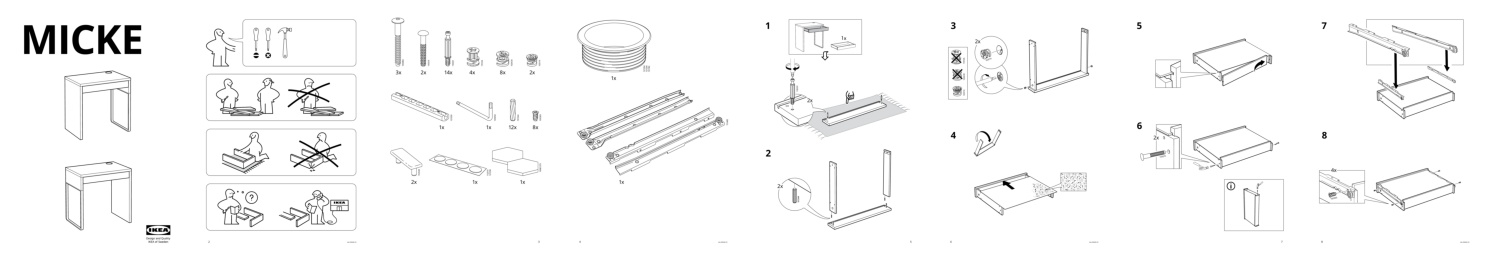

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Document retrievel

In [3]:
cache_dir = "/Users/wangzeyu/Desktop/Github projects/legalai-chatbot/huggingface-models"

In [4]:
## Document Retrieval

import torch
from PIL import Image
# from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.models import ColQwen2, ColQwen2Processor
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Any
import numpy as np

class DocumentRetriever:
    """
    Document retriever using the official ColPali/ColQwen2 model implementation.
    """
    
    def __init__(self, model_name="vidore/colqwen2-v1.0"):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        if torch.backends.mps.is_available():
            self.device = "mps"  # For Apple Silicon
            
        print(f"Using device: {self.device}")
        
        # Load the ColPali model and processor
        self.model = ColQwen2.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map=self.device,
            cache_dir=cache_dir
        ).eval()
        
        self.processor = ColQwen2Processor.from_pretrained(model_name, cache_dir=cache_dir)

        self.image_embeddings = []

    def index_images(self, images_dict: dict):
        """
        Index document images from a dictionary of PDF images.
        
        Args:
            images_dict (Dict[int, List[PIL.Image]]): Dictionary mapping document IDs to lists of PIL images.
                                                     Format: {doc_id: [page1_img, page2_img, ...], ...}
        """
        self.indexed_images = []
        self.image_embeddings = []
        
        # Process each document and its pages
        for doc_id, pages in images_dict.items():
            print(f"Processing document {doc_id} with {len(pages)} pages")
            
            # Process pages in batches
            batch_size = 4  # Adjust based on available memory
            for i in range(0, len(pages), batch_size):
                batch_pages = pages[i:i+batch_size]
                
                # Create identifiers for each page
                identifiers = [f"doc_{doc_id}_page_{i+page_idx}" for page_idx in range(len(batch_pages))]
                
                # Process images
                batch_images = self.processor.process_images(batch_pages).to(self.model.device)
                
                # Generate embeddings
                with torch.no_grad():
                    embeddings = self.model(**batch_images)
                
                # Store embeddings and identifiers
                self.image_embeddings.append(embeddings)
                self.indexed_images.extend(identifiers)
        
        print(f"Indexed {len(self.indexed_images)} pages from {len(images_dict)} documents")
    
    def retrieve(self, query: str, k: int = 3):
        """
        Retrieve relevant document images based on a text query.
        
        Args:
            query (str): The text query.
            k (int): Number of documents to retrieve.
            
        Returns:
            List[Dict]: List of retrieved documents with their paths and scores.
        """
        
        # Process the query
        batch_queries = self.processor.process_queries([query]).to(self.model.device)
        
        # Generate query embedding
        with torch.no_grad():
            query_embeddings = self.model(**batch_queries)
        
        # Calculate scores for all indexed images
        all_scores = []
        for image_embedding in self.image_embeddings:
            scores = self.processor.score_multi_vector(query_embeddings, image_embedding)
            all_scores.extend(scores.cpu().numpy().tolist())
        
        # Sort by score and get top-k
        # Create (path, score) pairs and sort by score (descending)
        scored_results = list(zip(self.indexed_images, all_scores))
        scored_results.sort(key=lambda x: x[1], reverse=True)
        
        # Return top-k results
        results = []
        for idx, score in scored_results[:k]:
            results.append({
                "image_id": idx,
                "score": score
            })
            
        return results

In [5]:
# Initialize the retriever
retriever = DocumentRetriever()

# Index images
retriever.index_images(all_images)

# Retrieve documents for a query
query = "How many people are needed to assemble the Malm?"
results = retriever.retrieve(query, k=3)

# Display results
print(f"Query: {query}")
print(f"Top {len(results)} results:")
for i, result in enumerate(results):
    print(f"{i+1}. {result['image_id']} (Score: {result['score']:.4f})")


Using device: mps


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

### Visualize the retrieved images

In [ ]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        identifier = result["image_id"]
        parts = identifier.split("_")
        doc_id = parts[1]
        page_num = int(parts[3])
        grouped_images.append(
            all_images[doc_id][page_num - 1]
        )  # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images


grouped_images = get_grouped_images(results, all_images)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Feed to the VLM for Question Answering

In [6]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
vlm = "HuggingFaceTB/SmolVLM-256M-Instruct"
cache_dir = '/Users/wangzeyu/Desktop/Github projects/legalai-chatbot/huggingface-models'

In [8]:
# Initialize processor and model
processor = AutoProcessor.from_pretrained(vlm, cache_dir=cache_dir)
model = AutoModelForVision2Seq.from_pretrained(
    vlm,
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager",
    cache_dir=cache_dir
).to(DEVICE)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
# create the chat structure by providing the system with the three 
# retrieved images along with the user query.
messages = [{"role": "user", "content": []}]
    
# Add all images to the message content
for image in grouped_images:
    messages[0]["content"].append({"type": "image"})
    
# Add the query text at the end
messages[0]["content"].append({"type": "text", "text": query})

In [ ]:
# Process the inputs to ensure they are properly formatted and 
# ready to be used as input for the Visual Language Model (VLM)
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=grouped_images, return_tensors="pt")
inputs = inputs.to(DEVICE)

In [ ]:
# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
# post process the generated outputs
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

In [ ]:
print(generated_texts[0])

In [ ]:
# # Optional: Function to handle memory optimization for many images
# def answer_with_batched_images(query, images, batch_size=3, max_tokens=500):
#     """
#     Process images in batches to avoid memory issues when dealing with many images.
    
#     Args:
#         query (str): The user's query
#         images (list): List of PIL Image objects
#         batch_size (int): Number of images to process per batch
#         max_tokens (int): Maximum number of tokens to generate
        
#     Returns:
#         str: Combined response from the model
#     """
#     if len(images) <= batch_size:
#         return answer_query_with_smolvlm(query, images, max_tokens)
    
#     # Process images in batches and collect responses
#     responses = []
#     for i in range(0, len(images), batch_size):
#         batch_images = images[i:i+batch_size]
#         batch_query = f"Analyze part {i//batch_size + 1} of the document: {query}"
#         response = answer_query_with_smolvlm(batch_query, batch_images, max_tokens)
#         responses.append(response)
    
#     # Send a final query to summarize all the partial responses
#     final_query = f"Based on all the document parts I've shown you, {query}"
#     combined_response = "\n\n".join(responses)
    
#     # You could optionally send the combined responses back to the model
#     # for a final summary if needed
    
#     return combined_response


### Assembling

### Next Step: Reranking

In [ ]:
class MultimodalRAGWithReranking(MultimodalRAG):
    """
    An enhanced multimodal RAG pipeline that includes a reranking step
    to improve retrieval quality.
    """
    
    def __init__(self, retriever, vlm_model_name="Salesforce/blip2-opt-2.7b", 
                 reranker_model_name="BAAI/bge-reranker-large"):
        """
        Initialize the enhanced multimodal RAG pipeline with reranking.
        
        Args:
            retriever: The document image retriever.
            vlm_model_name (str): The name of the VLM model to use.
            reranker_model_name (str): The name of the reranker model to use.
        """
        super().__init__(retriever, vlm_model_name)
        
        # Load the reranker model
        print(f"Loading reranker model: {reranker_model_name}")
        try:
            from sentence_transformers import CrossEncoder
            self.reranker = CrossEncoder(reranker_model_name)
        except ImportError:
            print("Warning: sentence-transformers package not found. Reranking will be skipped.")
            self.reranker = None
    
    def _extract_text_from_image(self, image):
        """
        Extract text from an image using OCR or the VLM's captioning ability.
        This is a simplified version that uses the VLM to generate a caption.
        
        Args:
            image (PIL.Image): The image to extract text from.
            
        Returns:
            str: The extracted text.
        """
        # Use the VLM to generate a caption for the image
        inputs = self.vlm_processor(images=image, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.vlm_model.generate(
                **inputs,
                max_length=50,
                num_beams=3,
                early_stopping=True
            )
            
            # Decode the generated text
            caption = self.vlm_processor.batch_decode(outputs, skip_special_tokens=True)[0]
        
        return caption
    
    def _rerank_images(self, query, image_paths, k=3):
        """
        Rerank the retrieved images based on their relevance to the query.
        
        Args:
            query (str): The query.
            image_paths (List[str]): List of image paths.
            k (int): Number of top images to return.
            
        Returns:
            List[str]: List of reranked image paths.
        """
        if self.reranker is None or not image_paths:
            return image_paths[:k]
        
        # Process the images to extract text/captions
        images = self._process_images_for_vlm(image_paths)
        captions = []
        
        for img in images:
            caption = self._extract_text_from_image(img)
            captions.append(caption)
        
        # Create query-document pairs for reranking
        pairs = [(query, caption) for caption in captions]
        
        # Score the pairs using the reranker
        scores = self.reranker.predict(pairs)
        
        # Sort the images by score
        reranked_indices = np.argsort(scores)[::-1][:k]
        
        # Return the reranked image paths
        return [image_paths[i] for i in reranked_indices]
    
    def answer_question(self, query, initial_k=5, final_k=3):
        """
        Answer a question based on retrieved and reranked document images.
        
        Args:
            query (str): The question to answer.
            initial_k (int): Number of images to initially retrieve.
            final_k (int): Number of images to keep after reranking.
            
        Returns:
            Dict: The answer and retrieved images.
        """
        # Retrieve relevant document images (retrieve more than we need for reranking)
        retrieved_docs = self.retriever.retrieve(query, k=initial_k)
        
        if not retrieved_docs:
            return {
                "answer": "No relevant documents found to answer the question.",
                "retrieved_images": []
            }
        
        # Get the image paths
        image_paths = [doc["image_path"] for doc in retrieved_docs]
        
        # Rerank the images
        reranked_paths = self._rerank_images(query, image_paths, k=final_k)
        
        # Process the reranked images for the VLM
        images = self._process_images_for_vlm(reranked_paths)
        
        if not images:
            return {
                "answer": "Failed to process the retrieved images.",
                "retrieved_images": []
            }
        
        # Generate answers for each image
        answers = []
        for img in images:
            # Prepare inputs for the VLM
            inputs = self.vlm_processor(images=img, text=query, return_tensors="pt").to(self.device)
            
            # Generate the answer
            with torch.no_grad():
                outputs = self.vlm_model.generate(
                    **inputs,
                    max_length=100,
                    num_beams=5,
                    early_stopping=True
                )
                
                # Decode the generated text
                generated_text = self.vlm_processor.batch_decode(outputs, skip_special_tokens=True)[0]
                answers.append(generated_text)
        
        # Combine the answers
        combined_answer = " ".join(answers)
        
        return {
            "answer": combined_answer,
            "retrieved_images": reranked_paths
        }


In [ ]:
# Example usage of the enhanced RAG pipeline with reranking

# Note: This is commented out to prevent immediate execution
"""
# Initialize the ColPali document retriever
retriever = ColPaliDocumentRetriever()

# Index the document images
retriever.index_documents(image_directory)

# Initialize the enhanced multimodal RAG pipeline with reranking
rag_with_reranking = MultimodalRAGWithReranking(retriever)

# Example query
query = "What are the rules for collecting gems in Splendor?"

# Get the answer
result = rag_with_reranking.answer_question(query, initial_k=5, final_k=3)

# Print the answer
print(f"Query: {query}")
print(f"Answer: {result['answer']}")

# Display the retrieved and reranked images
display_retrieved_images(result['retrieved_images'])
"""


## Further Improvements and Considerations

Here are some ways to enhance the multimodal RAG pipeline:

1. **OCR Integration**: Add proper OCR (Optical Character Recognition) to extract text from document images, which can improve reranking and answer generation.

2. **Hybrid Retrieval**: Combine image-based retrieval with text-based retrieval for more comprehensive results.

3. **Answer Fusion**: Implement more sophisticated methods for combining answers from multiple images, such as using an LLM to synthesize a coherent response.

4. **Chunking**: For multi-page documents, implement page chunking and handle document structure.

5. **User Feedback**: Incorporate user feedback to improve retrieval and answer quality over time.

6. **Caching**: Implement caching of embeddings and results to improve performance.

7. **Custom Fine-tuning**: Fine-tune the ColPali model and the VLM on your specific document domain for better performance.

8. **Multimodal Chain-of-Thought**: Implement a step-by-step reasoning process that leverages both text and visual information.

## References for Further Learning

1. **ColPali and Document Retrieval**:
   - [The Rise of Vision-Driven Document Retrieval for RAG](https://blog.vespa.ai/the-rise-of-vision-driven-document-retrieval-for-rag/)
   - [Multimodal RAG Using Document Retrieval and VLMs](https://huggingface.co/learn/cookbook/en/multimodal_rag_using_document_retrieval_and_vlms)
   - [Multimodal RAG with Reranking](https://huggingface.co/learn/cookbook/en/multimodal_rag_using_document_retrieval_and_reranker_and_vlms)

2. **Vision-Language Models**:
   - [BLIP-2: Bootstrapping Language-Image Pre-training](https://arxiv.org/abs/2301.12597)
   - [LLaVA: Large Language and Vision Assistant](https://llava-vl.github.io/)
   - [Gemini: A Family of Highly Capable Multimodal Models](https://arxiv.org/abs/2312.11805)

3. **Reranking for RAG**:
   - [Mastering RAG: How to Select a Reranking Model](https://galileo.ai/blog/mastering-rag-how-to-select-a-reranking-model)
   - [Re-ranking Mechanisms in RAG Pipelines](https://medium.com/@adnanmasood/re-ranking-mechanisms-in-retrieval-augmented-generation-pipelines-an-overview-8e24303ee789)

4. **Document Understanding**:
   - [DocVQA: A Dataset for VQA on Document Images](https://arxiv.org/abs/2007.00398)
   - [LayoutLM: Pre-training of Text and Layout for Document Image Understanding](https://arxiv.org/abs/1912.13318)
   - [Donut: Document Understanding Transformer](https://arxiv.org/abs/2111.15664)
